# Angular integration over "quad" grid

We have the following type of grid which we will integrate over

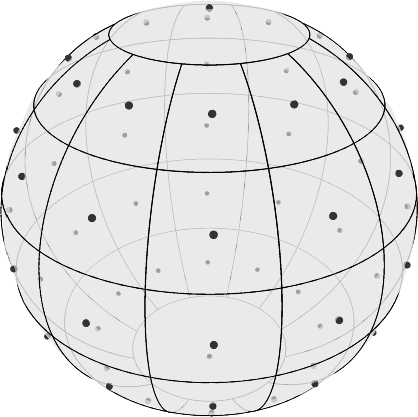

In [1]:
using Images
using FileIO
load("/home/oliver/academic/research/thesis/figures/png/angulargrid.png")

In [2]:
using Cubature
using Plots; pyplot()

Plots.PyPlotBackend()

In [32]:
function gengrid(nθ, nϕ)
    """Generate grid. nϕ includes poles."""
    dθ = 2π/(nθ)
    dϕ = π/(nϕ-1)

    l = 1:nθ
    m = 1:nϕ
    θ = collect((l-1)*dθ)
    ϕ = collect((m-1)*dϕ)
    ϕ[1] = 0
    ϕ[nϕ] = π

    # Edges between cells
    θe = θ+dθ/2
    ϕe = ϕ[1:nϕ-1]+dϕ/2
    ϕe[1] = dϕ/2
    ϕe[nϕ-1] = π - dϕ/2
    
    return dθ, θ, θe, dϕ, ϕ, ϕe
end

function plotgrid(θ, θe, ϕ, ϕe)
    l = @layout [a b]
    θs = linspace(0,2π,101)
    ϕs = linspace(0,π,101)
    # Azimuthal grid
    p = plot(cos.(θs), sin.(θs), label="", layout=l)
    plot!(p[1], cos.(θ), sin.(θ), marker=:circle, lw=0, label="cells")
    plot!(p[1], cos.(θe), sin.(θe), marker=:cross, lw=0, label="edges")
    plot!(p[1], aspectratio=1, legend=false)
    title!(p[1], "Azimuthal grid (\$\\theta\$)")
    # Polar grid
    plot!(p[2], sin.(ϕs), cos.(ϕs), label="")
    plot!(p[2], sin.(ϕ), cos.(ϕ), marker=:circle, lw=0, label="cells")
    plot!(p[2], sin.(ϕe), cos.(ϕe), marker=:cross, lw=0, label="edges")
    plot!(p[2], aspectratio=1, legend=false)
    title!(p[2], "Polar grid (\$\\phi\$)")
end

function angularquad(f, nθ, nϕ)
    dθ, θ, θe, dϕ, ϕ, ϕe = gengrid(nθ, nϕ)
    display(plotgrid(θ, θe, ϕ, ϕe))
    
    # Initialize with value only considering poles
    integ = 2π*(1-cos(dϕ/2))*(f[1,1]+f[1,nϕ])
    # Exclude poles
    for l=1:nθ
        for m=2:nϕ-1
            #println("l=$l, m=$m")
            integ += f[l,m] * dθ * (cos(ϕe[m-1])-cos(ϕe[m]))
        end
    end
    
    return integ
end

angularquad (generic function with 1 method)

In [35]:
function test_angularquad(f, nθ, nϕ)
    dθ, θ, θe, dϕ, ϕ, ϕe = gengrid(nθ, nϕ)
    f_arr = [f(θ1, ϕ1) for θ1=θ, ϕ1=ϕ]
    grid_integ = angularquad(f_arr, nθ, nϕ)
    println("grid_integ = $grid_integ")
    cubature, cube_err = pcubature(ω -> begin (θ, ϕ) = ω; sin.(ϕ)*f(θ, ϕ) end, (0.,0.), (2π,π), reltol=1e-3, abstol=1e-3)
    println("cubature = $cubature")
end

test_angularquad (generic function with 1 method)


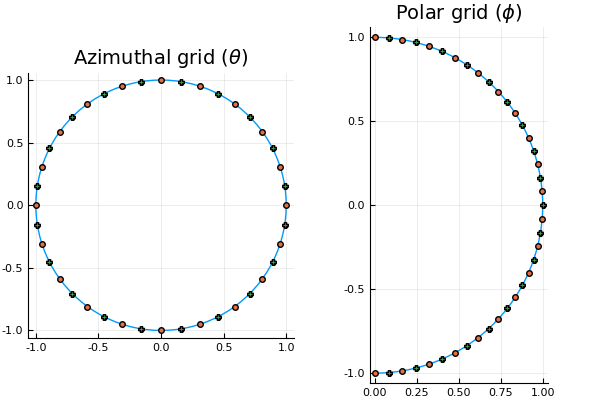

grid_integ = 9.901285799531172
cubature = 9.869604401089346


In [38]:
nθ = 20
nϕ = 20
f = (θ, ϕ) -> sin.(ϕ) .+ cos.(θ)
test_angularquad(f, nθ, nϕ)